# 제4 고지 : 신경망 만들기 
## STEP 46 : Optimizer로 수행하는 매개변수 갱신

지금까지는 경사하강법으로 매개변수를 갱신했지만, 이외에도 다양한 최적화 기법이 있다.  
이번 단계에서는 **매개변수 갱신 작업을 모듈화 하고 쉽게 다른 모듈로 대체할 수 있는 구조**를 만든다.

### 46.1 Optimizer 클래스

매개변수 갱신을 위한 기반 클래스인 `Optimizer` 클래스를 구현하고, 구체적인 최적화 기법은 `Optimizer` 를 상속받아 구현한다.

```python
class Optimizer:
    def __init__(self):
        self.target = None # 매개변수를 갖는 클래스 (Model 또는 Layer)
        self.hooks = [] # weight decay, gradient clipping 같은 매개변수 전처리 기법 처리

    def setup(self, target):
        self.target = target
        return self

    def update(self):
        # None 이외의 매개변수를 리스트에 모아둔다.
        params = [p for p in self.target.params() if p.grad is not None]

        # 전처리 (옵션)
        for f in self.hooks:
            f(params)

        # 매개변수 갱신
        for param in params:
            self.update_one(param)

    def update_one(self, param):
        # 구체적인 매개변수 갱신
        raise NotImplementedError()

    def add_hook(self, f):
        self.hooks.append(f)

```

### 46.2 SGD 클래스 구현
이제 경사하강법으로 매개변수를 갱신하는 `SGD`를 구현해보자.

```python
class SGD(Optimizer):
    def __init__(self,lr=0.01):
        super().__init__()
        self.lr = lr 
    def update_one(self,param):
        param.data-=self.lr*param.grad.data
```

### 46.3 SGD 클래스를 사용한 문제 해결


variable(0.8165178492839196)
variable(0.24990280802148895)
variable(0.24609876581126017)
variable(0.2372159081431807)
variable(0.20793216413350174)
variable(0.12311905720649353)
variable(0.07888166506355146)
variable(0.07655073683421637)
variable(0.07637803086238222)
variable(0.07618764131185564)


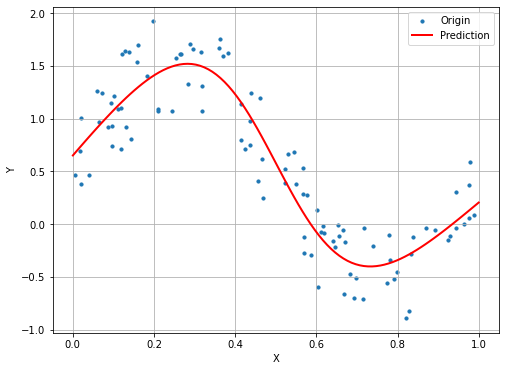

In [2]:
import sys
sys.path.append("..")

import numpy as np 
from dezero import Variable
from dezero import optimizers
import dezero.functions as F 
from dezero.models import MLP

# 토이 데이터셋
np.random.seed(0)
x = np.random.rand(100,1)
y = np.sin(2 *np.pi *x) + np.random.rand(100,1) #  데이터 생성에 sin 함수 이용



# 하이퍼 파라미터
lr = 0.2
iters = 10000
hidden_size=10

##################################################
# 모델 정의
model = MLP((hidden_size,1))
optimizer = optimizers.SGD(lr)
optimizer.setup(model) 
##################################################



# 신경망 학습
for i in range(iters):
    y_pred = model(x)
    loss = F.mean_squared_error(y,y_pred)
    
    model.cleargrads()
    
    loss.backward()

    ##################################################
    optimizer.update()
    ##################################################
    
    if i % 1000 == 0:
        print(loss)
        
# 그래프로 시각화
import matplotlib.pyplot as plt
x_test = np.linspace(0, 1, 100).reshape(100,1)

y_pred = model(x_test)

plt.figure(figsize=(8, 6))
plt.scatter(x, y, label='Origin', s=10)
plt.plot(x_test, y_pred.data, label='Prediction', color='red', linewidth=2)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

### 46.4 SGD 이외의 최적화 기법

기울기를 이용한 최적화기법은 다양하다. 대표적으로 Momentum,AdaGrad,AdaDelta,Adam 등을 들 수 있다.  
이제 `Opitimizer` 클래스 구현을 통해 손쉬운 최적화 기법을 구현 가능하므로, Momentum 을 하나의 예시로 구현해본다.

<span style='background-color : #ffdce0'>💡<b>이외의 최적화 기법은 `dezero/optimizers.py`를 참고한다.</b></span>

우선 Momentum 기법의 수식은 다음과 같다.
$$
\mathbf{v} \leftarrow \alpha\mathbf{v} - \eta \frac{\partial L}{\partial \mathbf{W}}
$$
$$
\mathbf{W} \leftarrow \mathbf{W} + \mathbf{v}
$$

여기서 $\mathbf{v}$ 는 '속도'를 의미한다. 즉, 위의 식은 **물체가 기울기 방향으로 힘을 받아 가속**된다는 것을 의미한다. 그리고 **그 속도만큼 매개변수가 업데이트** 된다.

<span style='background-color : #ffdce0'>💡<b>$\alpha\mathbf{v}$ 항은 물체가 아무런 힘을 받지 않을때 서서히 감속시키는 역할을 하는데, 일반적으로 0.9 로 설정한다.</b></span>

이제 이를 `MomentumSGD` 클래스로 구현하면 다음과 같다. 

```python
class MomentumSGD(Optimizer):
    def __init__(self, lr=0.01, momentum=0.9):
        super().__init__()
        self.lr = lr
        self.momentum = momentum
        self.vs = {} # 각 매개변수 마다 속도 

    def update_one(self, param):
        v_key = id(param)
        if v_key not in self.vs:
            self.vs[v_key] = np.zeros_like(param.data)

        v = self.vs[v_key]
        v *= self.momentum
        v -= self.lr * param.grad.data
        param.data += v
```
